# Ricci Flow Clustering algorithm for high dimensional data

Based on: 
* https://github.com/saibalmars/GraphRicciCurvature/blob/master/notebooks/tutorial.ipynb
* https://www.nature.com/articles/s41598-019-46380-9

By considering networks as geometric objects and communities in a network as a geometric
decomposition, we apply curvature and discrete Ricci flow, which have been used to decompose smooth manifolds with
astonishing successes in mathematics, to break down communities in networks. We apply this method to k-NN graphs obtained from high dimensional data.

In [1]:
!git branch

* master


In [2]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [3]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import cluster

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import umap
from collections import Counter
from scipy.stats import mode

from scipy.spatial.distance import euclidean

sns.set()

In [4]:
import GraphRicciCurvature
print(GraphRicciCurvature.__version__)

0.5.3.1


In [5]:
import networkx as nx
import numpy as np
import math

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci

# load python-louvain for modularity computation
import community as community_louvain

# for ARI computation
from sklearn import preprocessing, metrics

## Get data, UMAP graph and UMAP low dimensional vectors

In [24]:
dataset_id=0
raw_data, targets, dataset_name = get_dataset(dataset_id=dataset_id)

k = get_dataset_params(dataset_id)['n_neighbors']

In [16]:
# print(f'We are building a {k}-NN graph for dataset {dataset_name}')
# A_umap, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_data, 
#                                              n_neighbors=k, 
#                                              random_state=0, 
#                                              metric='euclidean', 
#                                              return_dists=True,
#                                              set_op_mix_ratio=1)
# umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)

# A = (A_umap > 0)
# G = nx.from_scipy_sparse_matrix(A)

In [25]:
print(f'We are building a directed {k}-NN graph for dataset {dataset_name}')
G = knn_digraph(raw_data, k=k, graph_type='nx')

We are building a directed 15-NN graph for dataset pendigits


In [30]:
print("\n=====  Compute Ricci flow metric - Optimal Transportation Distance =====")

orc_OTD = OllivierRicci(G, alpha=0.5, method="OTD", verbose="INFO")
orc_OTD.compute_ricci_flow(iterations=10)


=====  Compute Ricci flow metric - Optimal Transportation Distance =====


2023-03-21 16:36:45,650 - OllivierRicci - INFO - No ricciCurvature detected, compute original_RC...
2023-03-21 16:36:46,666 - OllivierRicci - INFO - 0.583161 secs for Ricci curvature computation.
2023-03-21 16:36:46,927 - OllivierRicci - INFO -  === Ricci flow iteration 0 === 
2023-03-21 16:36:47,933 - OllivierRicci - INFO - 0.561057 secs for Ricci curvature computation.
2023-03-21 16:36:48,183 - OllivierRicci - INFO -  === Ricci flow iteration 1 === 
2023-03-21 16:36:49,180 - OllivierRicci - INFO - 0.564841 secs for Ricci curvature computation.
2023-03-21 16:36:49,432 - OllivierRicci - INFO -  === Ricci flow iteration 2 === 
2023-03-21 16:36:50,432 - OllivierRicci - INFO - 0.570502 secs for Ricci curvature computation.
2023-03-21 16:36:50,683 - OllivierRicci - INFO -  === Ricci flow iteration 3 === 
2023-03-21 16:36:51,677 - OllivierRicci - INFO - 0.564937 secs for Ricci curvature computation.
2023-03-21 16:36:51,928 - OllivierRicci - INFO -  === Ricci flow iteration 4 === 
2023-03-21

In [34]:
orc_OTD.G.edges([0], data=True)

EdgeDataView([(0, 877, {'weight': 0.24875737407386794, 'bi_directional': True, 'ricciCurvature': 0.04177100887824581, 'original_RC': 0.9254457474510525}), (0, 1365, {'weight': 0.26803208161942393, 'bi_directional': True, 'ricciCurvature': 0.05419709529298167, 'original_RC': 0.9277631139748483}), (0, 1541, {'weight': 0.6195173709040442, 'bi_directional': True, 'ricciCurvature': 0.02008555451854266, 'original_RC': 0.7479680722797124}), (0, 1167, {'weight': 0.2598946446087138, 'bi_directional': True, 'ricciCurvature': 0.044818307521499734, 'original_RC': 0.9130334183468696}), (0, 1029, {'weight': 0.2789131175674377, 'bi_directional': True, 'ricciCurvature': 0.04579851115098765, 'original_RC': 0.8848329571861592}), (0, 464, {'weight': 0.6784099121638039, 'bi_directional': True, 'ricciCurvature': 0.043305527151442424, 'original_RC': 0.7283469672574134}), (0, 957, {'weight': 1.0725231963836426, 'bi_directional': True, 'ricciCurvature': 0.0015872063386352941, 'original_RC': 0.2463341351961090

In [27]:
%%time
print("\n=====  Compute Ricci community - by Ricci flow =====")
clustering = orc_OTD.ricci_community()

2023-03-21 16:17:57,616 - OllivierRicci - INFO - Ricci flow not detected yet, run Ricci flow with default setting first...
2023-03-21 16:17:57,642 - OllivierRicci - INFO - No ricciCurvature detected, compute original_RC...



=====  Compute Ricci community - by Ricci flow =====


2023-03-21 16:17:58,662 - OllivierRicci - INFO - 0.586883 secs for Ricci curvature computation.
2023-03-21 16:17:58,918 - OllivierRicci - INFO -  === Ricci flow iteration 0 === 
2023-03-21 16:18:01,286 - OllivierRicci - INFO - 1.216654 secs for Ricci curvature computation.
2023-03-21 16:18:02,054 - OllivierRicci - INFO -  === Ricci flow iteration 1 === 
2023-03-21 16:18:04,257 - OllivierRicci - INFO - 1.366657 secs for Ricci curvature computation.
2023-03-21 16:18:04,908 - OllivierRicci - INFO -  === Ricci flow iteration 2 === 
2023-03-21 16:18:07,084 - OllivierRicci - INFO - 1.266373 secs for Ricci curvature computation.
2023-03-21 16:18:07,573 - OllivierRicci - INFO -  === Ricci flow iteration 3 === 
2023-03-21 16:18:09,470 - OllivierRicci - INFO - 1.065014 secs for Ricci curvature computation.
2023-03-21 16:18:10,040 - OllivierRicci - INFO -  === Ricci flow iteration 4 === 
2023-03-21 16:18:12,504 - OllivierRicci - INFO - 1.630779 secs for Ricci curvature computation.
2023-03-21 16:

CPU times: user 2min 36s, sys: 7.42 s, total: 2min 44s
Wall time: 2min 8s


In [28]:
labels = list(clustering[1].values())
ari = adjusted_rand_score(targets, labels)
ami = adjusted_mutual_info_score(targets, labels)
print(f'ARI = {ari} and AMI = {ami}') 

ARI = -0.003938781961610883 and AMI = -0.008027498514716966


In [ ]:
nx.

In [11]:
import community as community_louvain

In [13]:
# Equation 14 from CAMEL paper

def update_weights(G, w_max, epsilon = 0.01):
    
    rescale = (G.number_of_edges()/G.size(weight="weight"))
    G_tmp = G.copy()
    
    rescale_w = {
        (u, v): 
        {'weight': ed['weight']*rescale} for u, v, ed in G.edges.data()
    }
    nx.set_edge_attributes(G_tmp, rescale_w)
    
    orc = OllivierRicci(G_tmp, alpha=0.5, verbose="TRACE")
    orc.compute_ricci_curvature()
    G_orc = orc.G.copy()  # save an intermediate result
    
    res = {
        (u, v): 
        {'weight': max( 0, ed['weight'] - 2*epsilon*(G_orc.nodes[u]['ricciCurvature']+G_orc.nodes[v]['ricciCurvature']) )} 
        for u, v, ed in G_tmp.edges.data(data=True)
    }
    return(res)

In [ ]:
for i in range(4):
    louvain_communities = list(community_louvain.best_partition(G, random_state=0).values())
    ari = adjusted_rand_score(targets, louvain_communities)
    ami = adjusted_mutual_info_score(targets, louvain_communities)
    w_max = max([ed['weight'] for u, v, ed in G.edges.data(data=True)])
    
    print(f'Round {i}: max edge weight is {w_max}\nARI = {ari} and AMI = {ami}')   
    
    new_weights =  update_weights(G, w_max)
    nx.set_edge_attributes(G, new_weights)
    ebunch = [(u,v) for u, v, ed in G.edges.data(data=True) if ed['weight']<0.01]
    G.remove_edges_from(ebunch)

In [10]:
import networkx as nx
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci

print("\n- Import an example NetworkX karate club graph")
G = nx.karate_club_graph()

print("\n===== Compute the Ollivier-Ricci curvature of the given graph G =====")
# compute the Ollivier-Ricci curvature of the given graph G
orc = OllivierRicci(G, alpha=0.5, verbose="INFO")
orc.compute_ricci_curvature()
print("Karate Club Graph: The Ollivier-Ricci curvature of edge (0,1) is %f" % orc.G[0][1]["ricciCurvature"])

print("\n===== Compute the Forman-Ricci curvature of the given graph G =====")
frc = FormanRicci(G)
frc.compute_ricci_curvature()
print("Karate Club Graph: The Forman-Ricci curvature of edge (0,1) is %f" % frc.G[0][1]["formanCurvature"])

# -----------------------------------
print("\n=====  Compute Ricci flow metric - Optimal Transportation Distance =====")
G = nx.karate_club_graph()
orc_OTD = OllivierRicci(G, alpha=0.5, method="OTD", verbose="INFO")
orc_OTD.compute_ricci_flow(iterations=10)
print("\n=====  Compute Ricci community - by Ricci flow =====")
clustering = orc_OTD.ricci_community()

2023-03-20 18:59:55,246 - OllivierRicci - INFO - Edge weight not detected in graph, use "weight" as default edge weight.



- Import an example NetworkX karate club graph

===== Compute the Ollivier-Ricci curvature of the given graph G =====


2023-03-20 18:59:55,846 - OllivierRicci - INFO - 0.589710 secs for Ricci curvature computation.
2023-03-20 18:59:55,849 - FormanRicci - INFO - Edge weight not detected in graph, use "weight" as default edge weight.
2023-03-20 18:59:55,849 - FormanRicci - INFO - Node weight not detected in graph, use "weight" as default node weight.
2023-03-20 18:59:55,853 - OllivierRicci - INFO - Edge weight not detected in graph, use "weight" as default edge weight.
2023-03-20 18:59:55,854 - OllivierRicci - INFO - No ricciCurvature detected, compute original_RC...


Karate Club Graph: The Ollivier-Ricci curvature of edge (0,1) is 0.111111

===== Compute the Forman-Ricci curvature of the given graph G =====
Karate Club Graph: The Forman-Ricci curvature of edge (0,1) is 0.000000

=====  Compute Ricci flow metric - Optimal Transportation Distance =====


2023-03-20 18:59:56,386 - OllivierRicci - INFO - 0.530529 secs for Ricci curvature computation.
2023-03-20 18:59:56,389 - OllivierRicci - INFO -  === Ricci flow iteration 0 === 
2023-03-20 18:59:56,909 - OllivierRicci - INFO - 0.519525 secs for Ricci curvature computation.
2023-03-20 18:59:56,912 - OllivierRicci - INFO -  === Ricci flow iteration 1 === 
2023-03-20 18:59:57,455 - OllivierRicci - INFO - 0.540801 secs for Ricci curvature computation.
2023-03-20 18:59:57,457 - OllivierRicci - INFO -  === Ricci flow iteration 2 === 
2023-03-20 18:59:58,006 - OllivierRicci - INFO - 0.547091 secs for Ricci curvature computation.
2023-03-20 18:59:58,009 - OllivierRicci - INFO -  === Ricci flow iteration 3 === 
2023-03-20 18:59:58,559 - OllivierRicci - INFO - 0.548626 secs for Ricci curvature computation.
2023-03-20 18:59:58,562 - OllivierRicci - INFO -  === Ricci flow iteration 4 === 
2023-03-20 18:59:59,102 - OllivierRicci - INFO - 0.539006 secs for Ricci curvature computation.
2023-03-20 18:


=====  Compute Ricci community - by Ricci flow =====


AttributeError: 'list' object has no attribute 'items'

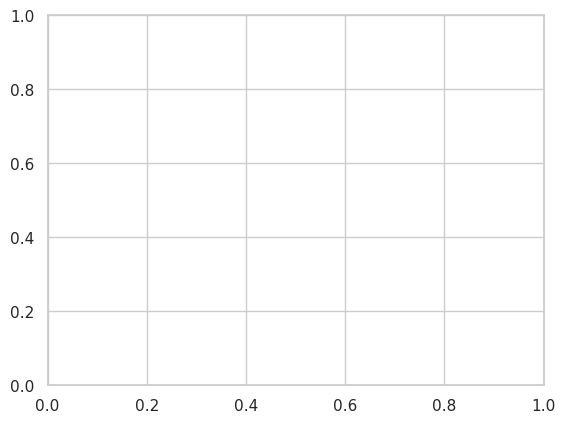

In [13]:
pos = nx.spring_layout(G, seed=3113794652)  # positions for all nodes
nx.draw_networkx_labels(G, pos=pos, labels = list(clustering[1].values()))

In [19]:
pos

{0: array([0.27933992, 0.21289285]),
 1: array([0.11722523, 0.2338933 ]),
 2: array([-0.01139837,  0.0047608 ]),
 3: array([0.10201642, 0.34242587]),
 4: array([0.6238287 , 0.36455273]),
 5: array([0.72891721, 0.1463939 ]),
 6: array([0.74023642, 0.26623287]),
 7: array([0.01513966, 0.31295539]),
 8: array([-0.12875003,  0.04859826]),
 9: array([ 0.04290113, -0.19445973]),
 10: array([0.60211232, 0.2061179 ]),
 11: array([0.41058371, 0.61454636]),
 12: array([0.17709171, 0.56270319]),
 13: array([-0.01103545,  0.1450135 ]),
 14: array([-0.60704258, -0.02429042]),
 15: array([-0.52782907,  0.05968732]),
 16: array([1.        , 0.19697871]),
 17: array([0.39005528, 0.36900437]),
 18: array([-0.63150159, -0.12862366]),
 19: array([0.10506698, 0.0096783 ]),
 20: array([-0.62378195, -0.23211394]),
 21: array([0.28614154, 0.4652185 ]),
 22: array([-0.5785844 , -0.33220839]),
 23: array([-0.38032792, -0.44334852]),
 24: array([-0.07480858, -0.60777356]),
 25: array([-0.24465807, -0.63428595])